#Training of Mask Dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

- insert path to both image files
- run edits and train model
- test on random 5 images
- prune model
- save model weights
- download.py and try running on local computer with the necessary dependancies
- after that upload to github with appropriate credits


In [ ]:
#colab imports - change if exporting elsewhere
from google.colab import drive
import zipfile
drive.mount('/content/drive')


#global variables
with_mask_loc = "/content/drive/My Drive/Symsense_Models/with_mask.zip"
without_mask_loc = "/content/drive/My Drive/Symsense_Models/without_mask.zip"


zip_ref_with_mask = zipfile.ZipFile(with_mask_loc, 'r')
zip_ref_without_mask = zipfile.ZipFile(without_mask_loc, 'r')
zip_ref_with_mask.extractall("/tmp")
zip_ref_with_mask.close()
zip_ref_without_mask.extractall("/tmp")
zip_ref_without_mask.close()


Mounted at /content/drive


In [ ]:
with_mask_loc = '/tmp/with_mask/'
without_mask_loc ='/tmp/without_mask/'
model_store = "/content/drive/My Drive/Symsense_Models/"
#print(os.listdir(with_mask_loc))

In [ ]:
learn_rate = 1e-4
epochs = 25
batch_size = 32

image_list = []
label_list = []
imagePaths_mask = [with_mask_loc + i for i in os.listdir(with_mask_loc)]
imagePaths_without_mask = [without_mask_loc + i for i in os.listdir(without_mask_loc)]
#load all images as array


def load_images(imagePaths):
  data,labels = [],[]
  for imagePath in imagePaths:
    # extract the class label from the filename    
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
  
  return data,labels


#have load of no mask images
image_list_mask, label_list_mask = load_images(imagePaths_mask)
image_list_without_mask, label_list_without_mask = load_images(imagePaths_without_mask)

image_list = image_list_mask + image_list_without_mask
label_list = label_list_mask + label_list_without_mask
print(len(image_list))

1376


In [ ]:
data = np.array(image_list, dtype="float32")
print(data.shape)
labels = np.array(label_list)
print(labels.shape)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(1376, 224, 224, 3)
(1376,)


In [ ]:


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
# construct the training image generator for data augmentation

(trainX, testX, trainY, testY) = train_test_split(data, labels,
  test_size=0.20, stratify=labels, random_state=42)


In [ ]:

#have mobilenet v2 setup
class image_model_class:

  def __init__(self):
    self.pool_size = 7
    self.activation = 'softmax'
    self.learn_rate = 1e-4
    self.epochs = 50

    self.batch_size = 32
    self.aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

  def make_model(self):
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
	    input_tensor=Input(shape=(224, 224, 3)))
    
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
	    layer.trainable = False

    return model


  def compile_fit(self,trainX, trainY,testX, testY):
    opt = Adam(lr=learn_rate, decay=learn_rate /epochs)
    model = self.make_model()
    model.compile(loss="binary_crossentropy", optimizer=opt,
	    metrics=["accuracy"])
    

    H = model.fit(
      self.aug.flow(trainX, trainY, batch_size=self.batch_size),
      steps_per_epoch=len(trainX) // self.batch_size,
      validation_data=(testX, testY),
      validation_steps=len(testX) // self.batch_size,
      epochs=self.epochs)
    

    return model,H


    

imc = image_model_class()
model,H = imc.compile_fit(trainX, trainY,testX, testY)





Epoch 1/50
34/34 [==============================] - 19s 475ms/step - loss: 0.7007 - accuracy: 0.6549 - val_loss: 0.2581 - val_accuracy: 0.9891
Epoch 2/50
34/34 [==============================] - 14s 396ms/step - loss: 0.2518 - accuracy: 0.9633 - val_loss: 0.1201 - val_accuracy: 0.9928
Epoch 3/50
34/34 [==============================] - 14s 398ms/step - loss: 0.1579 - accuracy: 0.9694 - val_loss: 0.0707 - val_accuracy: 0.9964
Epoch 4/50
34/34 [==============================] - 14s 400ms/step - loss: 0.0851 - accuracy: 0.9902 - val_loss: 0.0489 - val_accuracy: 0.9964
Epoch 5/50
34/34 [==============================] - 14s 402ms/step - loss: 0.0705 - accuracy: 0.9909 - val_loss: 0.0369 - val_accuracy: 0.9964
Epoch 6/50
34/34 [==============================] - 13s 393ms/step - loss: 0.0514 - accuracy: 0.9959 - val_loss: 0.0297 - val_accuracy: 0.9964
Epoch 7/50
34/34 [==============================] - 13s 386ms/step - loss: 0.0501 - accuracy: 0.9893 - val_loss: 0.0256 - val_accuracy: 0.9964

In [ ]:
from tensorflow import keras
keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



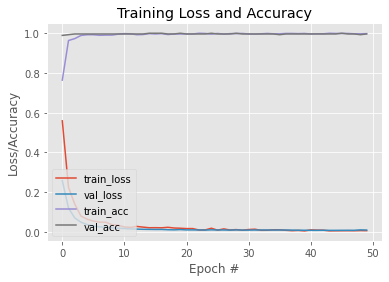

In [ ]:
#evaluation of model
print("[INFO] evaluating network...")




predIdxs = model.predict(testX, batch_size=batch_size)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

N = imc.epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


model.save('model', save_format="h5")

There is an issue of overfitting - and this will be considered later

Save the model below
